<a href="https://colab.research.google.com/github/CitricAmoeba/INT2-Group2/blob/main/CIFAR10_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [11]:
# Composition of several image transformations to perform on the data
transform = transforms.Compose(
    [transforms.RandomCrop(32, 4),
     transforms.RandomHorizontalFlip(),
     transforms.ColorJitter(0.25, 0.25),
     transforms.RandomAffine(10),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])

batch_size = 16

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = trainset.classes

accuracy = []
avg_loss = []

Files already downloaded and verified
Files already downloaded and verified


In [12]:
import torch.nn as nn
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 200, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(200, 64, 5)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(64 * 5 * 5, 220)
        self.fc2 = nn.Linear(220, 120)
        self.fc4 = nn.Linear(120, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout2(x)

        x = x.view(-1, 64 * 5 * 5)
        
        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)
        x = F.relu(x)

        x = self.fc4(x)

        return x


net = Net()
net.to(device)

print(net)

Using cuda device
Net(
  (conv1): Conv2d(3, 200, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(200, 64, kernel_size=(5, 5), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=1600, out_features=220, bias=True)
  (fc2): Linear(in_features=220, out_features=120, bias=True)
  (fc4): Linear(in_features=120, out_features=10, bias=True)
)


In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=1e-2, momentum=0.98)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-5, max_lr=1e-2, step_size_up=1000)

In [14]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        if batch % int(len(dataloader)/5) == 0: # batch % 2000 == 1999:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}] lr: {scheduler.get_last_lr()}") # 


In [15]:
def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    accuracy.append(100*correct)
    avg_loss.append(test_loss)

In [28]:
epochs = 2

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(trainloader, net, loss_fn, optimizer)
    test(testloader, net)
    draw()
print("Done!")

Epoch 1
-------------------------------
loss: 0.692839  [    0/50000] lr: [0.007322679999999993]
loss: 0.413841  [10000/50000] lr: [0.0010789299999999934]
loss: 0.850516  [20000/50000] lr: [0.005184820000000007]
loss: 1.144083  [30000/50000] lr: [0.008571429999999993]
loss: 0.908017  [40000/50000] lr: [0.0023276799999999934]
Test Error: 
 Accuracy: 68.5%, Avg loss: 0.056657 



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 2
-------------------------------
loss: 1.096252  [    0/50000] lr: [0.003936070000000007]
loss: 0.861881  [10000/50000] lr: [0.009820179999999993]


KeyboardInterrupt: ignored

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

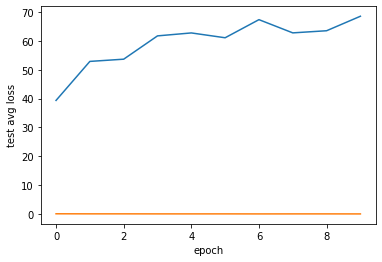

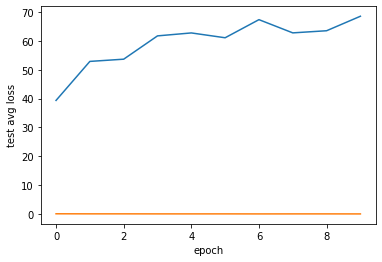

In [47]:
plt.xlabel('epoch')
plt.ylabel('test accuracy')
plt.plot(list(range(len(accuracy))), accuracy)

plt.figure()
plt.xlabel('epoch')
plt.ylabel('test avg loss')
plt.plot(list(range(len(avg_loss))), avg_loss)
plt.show()


In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for X, y in testloader:
        X, y = X.to(device), y.to(device)
        outputs = net(X)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == y).squeeze()
        for i in range(4):
            label = y[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
for i in range(10):
    print('Accuracy of %10s : %2d %%' % (
         classes[i], 100 * class_correct[i] / class_total[i]))